In [1]:
# to reproduce the figures in the paper
apache_test_run = "20250112_23_11"
gnome_test_run = "20250113_00_07"

# to generate figures for newly measured data,
# comment out the two lines above, uncomment the following,
# and set the value to the respective output folder under measurements:
#apache_test_run = "20250112_23_11"
#gnome_test_run = "20250113_00_07"

In [2]:
from sh import mount, umount
from pathlib import Path
import subprocess
import re
import pandas as pd
from IPython.display import display
from multiprocessing import Pool
import os.path
import numpy as np
import pickle

from part_util import *
from ima_ext4 import *
from ima_btrfs import *
from ima_xfs import *
from ima_f2fs import *
from ima_bcachefs import *

def merge_fss(d):
    cat = pd.concat([d["ext4"].set_index(['case', 'fs']),
                     d["btrfs"].set_index(['case', 'fs']),
                     d["xfs"].reset_index().set_index(['case', 'fs']),
                     d["bcachefs"].reset_index().set_index(['case', 'fs']),
                     d["f2fs"].reset_index().set_index(['case', 'fs'])
                    ]).fillna(0).astype(int).reset_index()
    cat.set_index(['case', 'fs'], inplace=True)
    cat = cat.reorder_levels(['fs', 'case']).sort_index()
    cat = cat.unstack(level=0)
    
    order = ['used', 'used_fragmented', 'meta', 'meta_fragmented', 'free', 'success']
    cat = cat[order]
    return cat

order = list(reversed([
        'none',
        'ecdsa-p256',
        'rsa-4096',
        'falcon512',
        'falcon1024',
        'mldsa44',
        'mldsa65',
        'mldsa87',
        'hss',
        'slhdsa128s',
        'slhdsa128f',
        'slhdsa192s', 
        'slhdsa192f',
        'slhdsa256s',
        'slhdsa256f'
    ]))

In [3]:
with open(f"../measurements/{apache_test_run}/ima_usage", 'rb') as f:
    data_apache = pickle.load(f)

In [4]:
with open(f"../measurements/{gnome_test_run}/ima_usage", 'rb') as f:
    data_gnome = pickle.load(f)

In [5]:
merged_apache = merge_fss(data_apache)
# eliminate sphincs-SHAKE rows
merged_apache = merged_apache[~merged_apache.index.str.contains('shake', na=False)]
merged_apache.index = merged_apache.index.str.replace('sha2', '', regex=True)
merged_apache.index = merged_apache.index.str.replace('lms', '', regex=True)
# strip use case (apache/gnome) from testcase
merged_apache.index = merged_apache.index.str.replace('_apache', '', regex=True)

In [6]:
merged_gnome = merge_fss(data_gnome)
# eliminate sphincs-SHAKE rows
merged_gnome = merged_gnome[~merged_gnome.index.str.contains('shake', na=False)]
merged_gnome.index = merged_gnome.index.str.replace('sha2', '', regex=True)
merged_gnome.index = merged_gnome.index.str.replace('lms', '', regex=True)
# strip use case (apache/gnome) from testcase
merged_gnome.index = merged_gnome.index.str.replace('_gnome', '', regex=True)

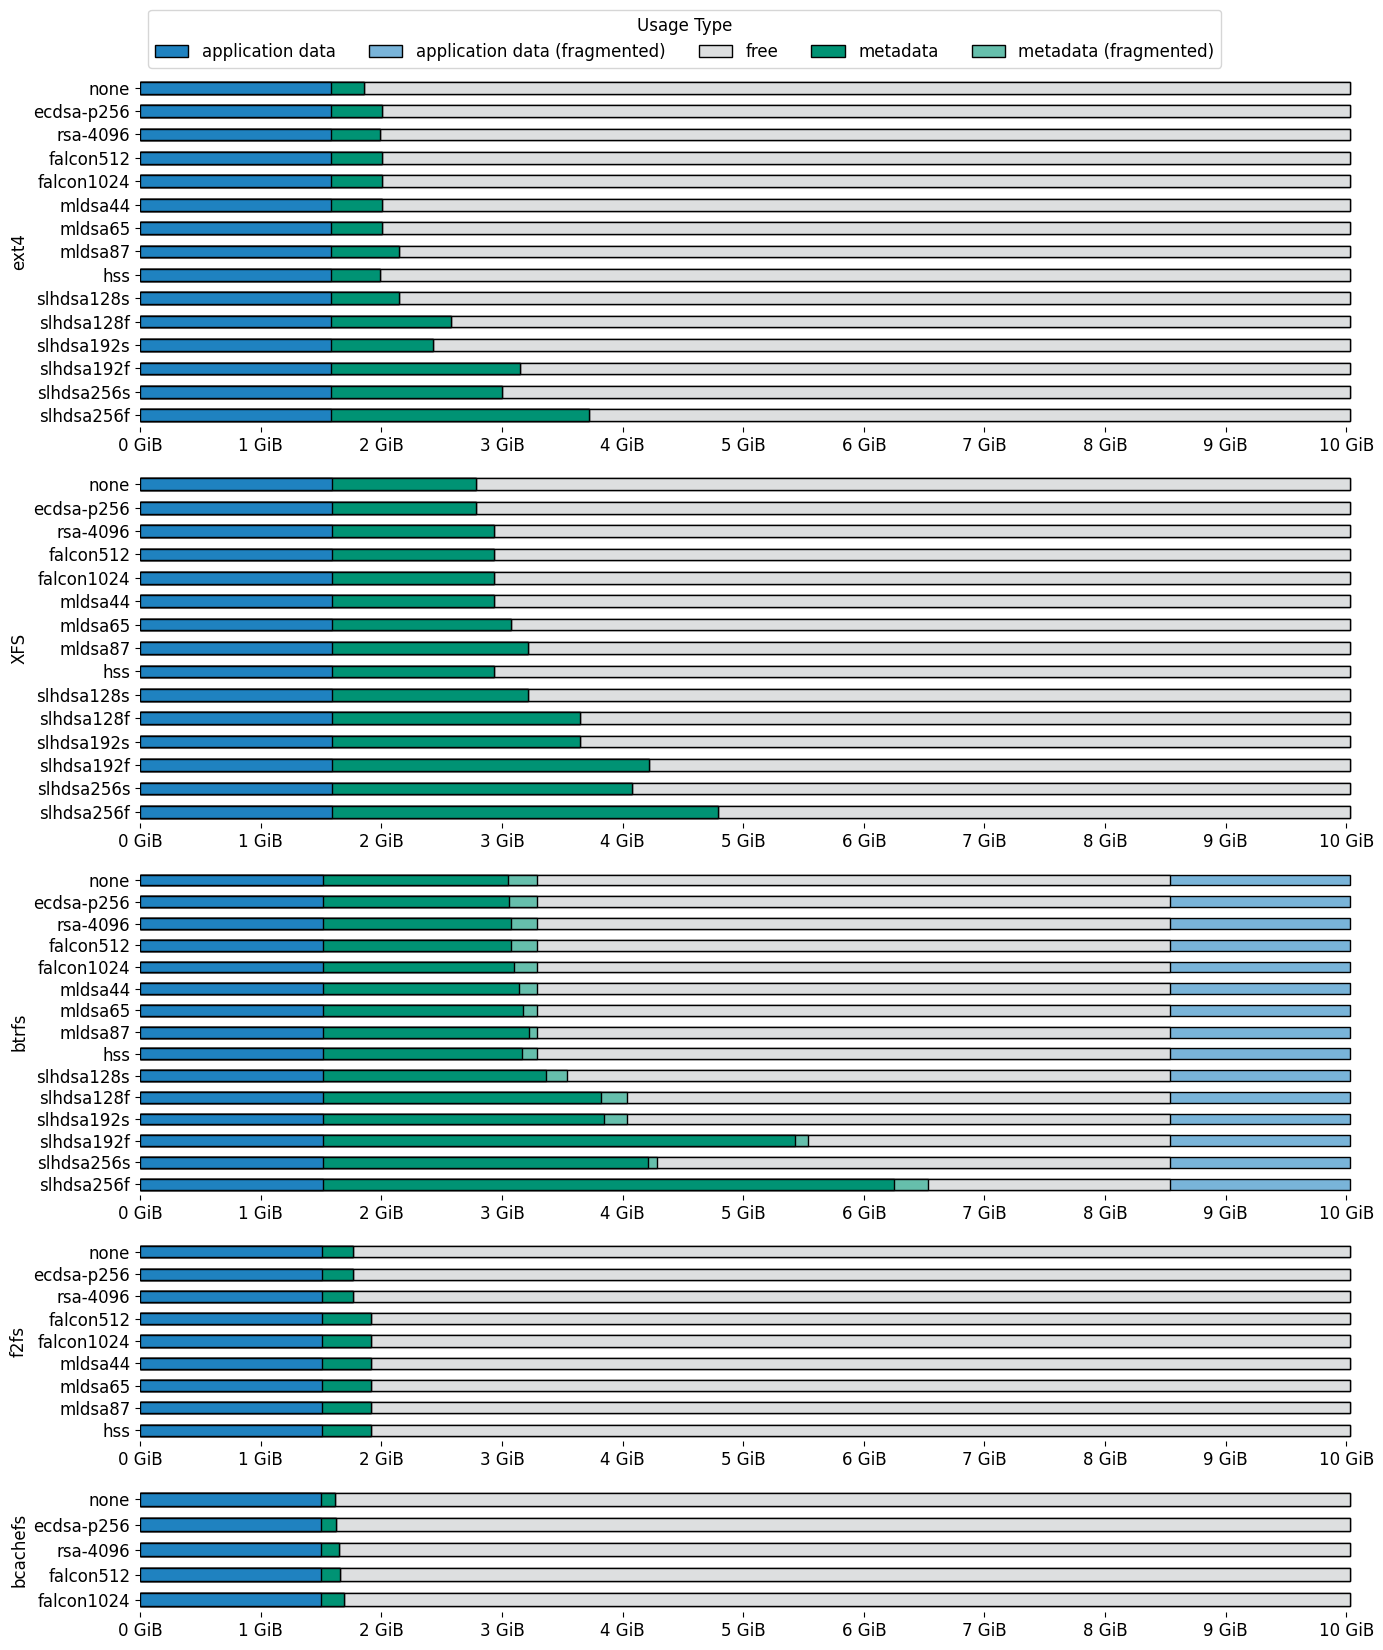

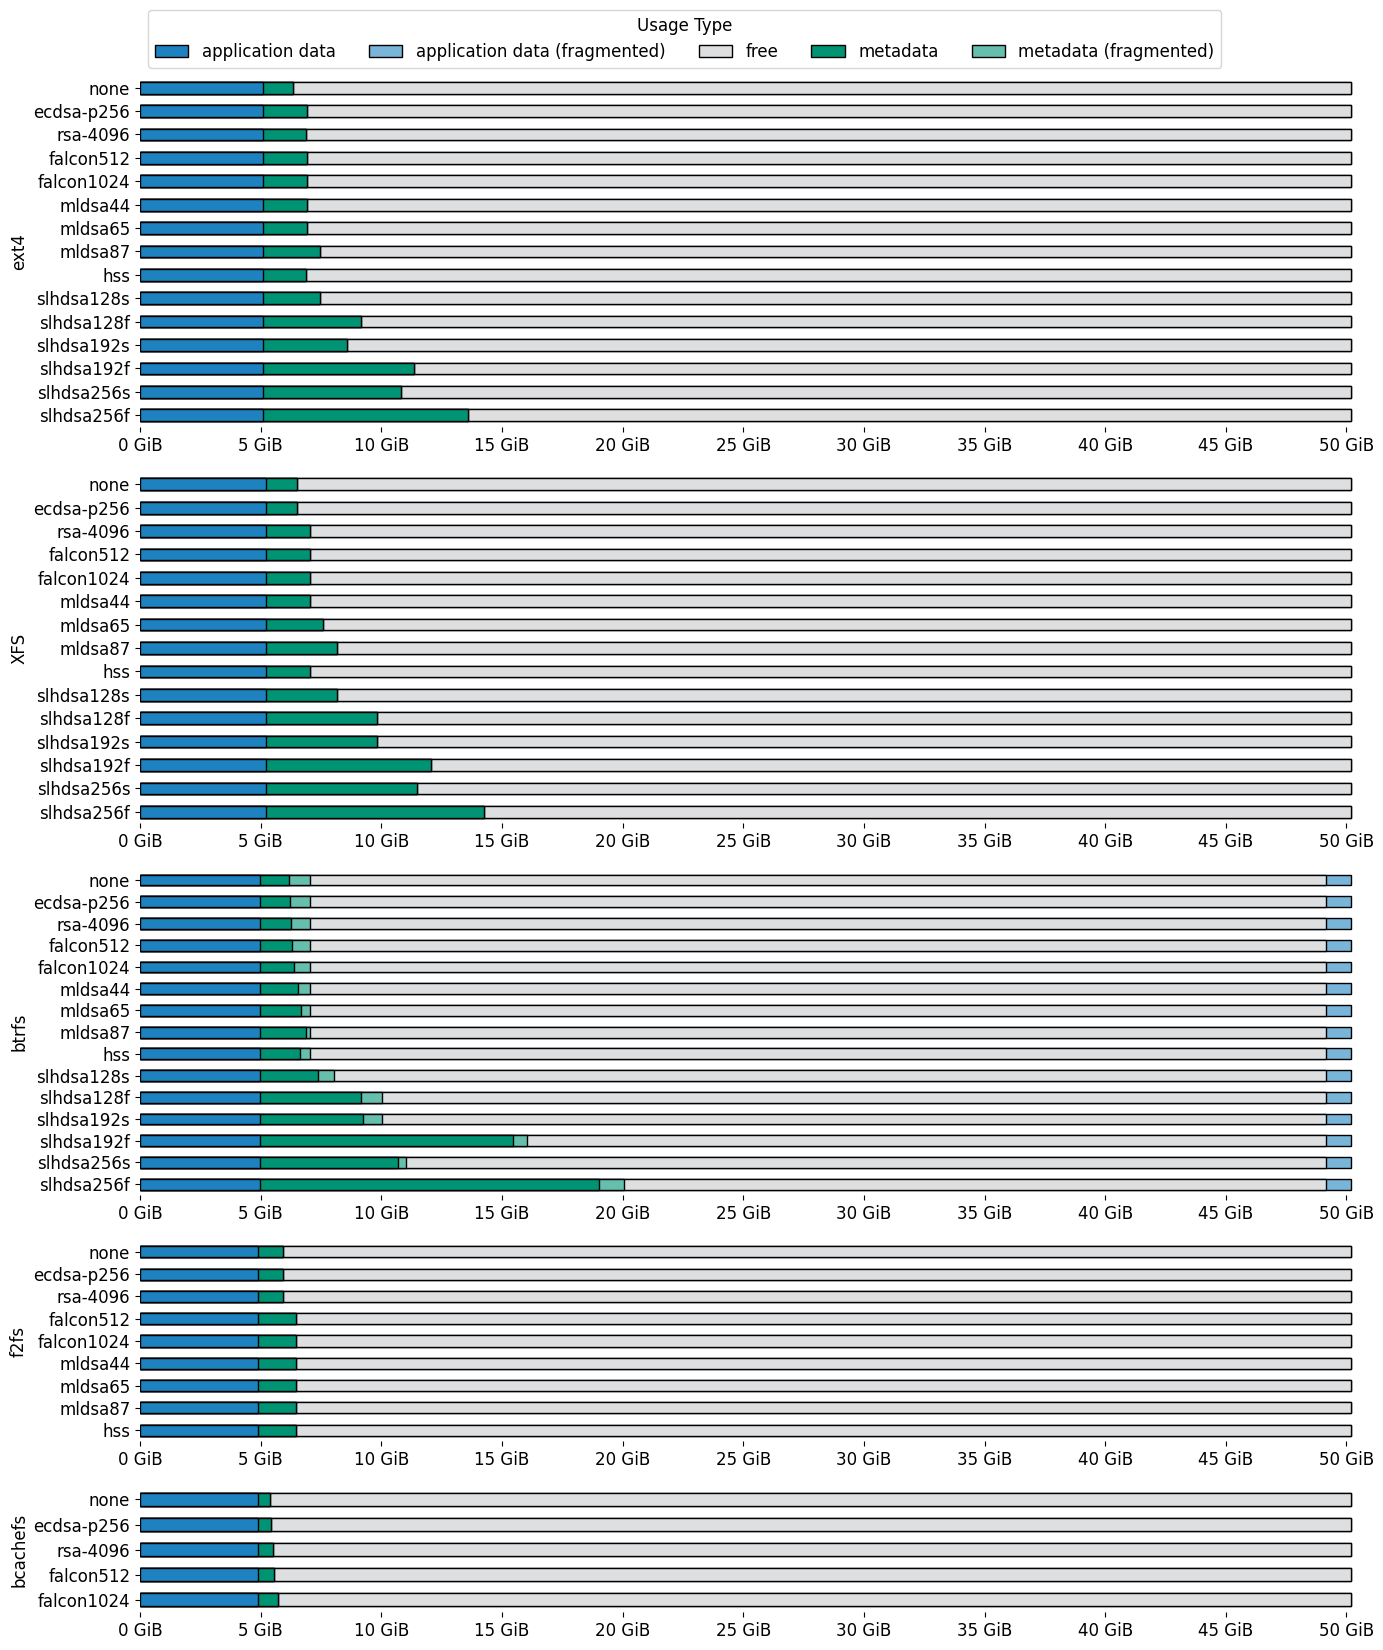

In [7]:
def plot_single_group(dfs, xstep=1, xlim=(0,10.1*2**30)):
    colors = ['#1F82C0', '#79B4D9', '#009374', '#66BFAC', '#DDDFE0']
    plt.rcParams.update({'font.size': 12})
    fig,axs = plt.subplots(len(dfs), 1, sharey=False, figsize=(14, 16), gridspec_kw={'height_ratios': [14, 14, 13, 8, 5]})

    dfs = [ (df[df['success'] == 1].copy(), fs) for (df, fs) in dfs ]

    for (i,((df, fs), ax)) in enumerate(list(zip(dfs, axs))):
        df.index = df.index.str.replace('sphincs', 'slhdsa', regex=True)
        df.index = df.index.str.replace('simple', '', regex=True)
        df.index = df.index.str.replace('prime256v1', 'ecdsa-p256', regex=True)

        df.sort_values(by="case", key=lambda column: column.map(lambda e: order.index(e)), inplace=True)

        (df['free']+df['meta_fragmented']+df['meta']+df['used_fragmented']+df['used']).plot.barh(ax=ax, edgecolor="black", color=colors[1], label='used (fragmented)') # used_fragmented
        (df['free']+df['meta_fragmented']+df['meta']+df['used']).plot.barh(ax=ax, edgecolor="black", color=colors[4], label='free') # free
        (df['meta_fragmented']+df['meta']+df['used_fragmented']+df['used']).plot.barh(ax=ax, edgecolor="black", color=colors[3], label='metadata (fragmented)') # meta
        (df['meta']+df['used_fragmented']+df['used']).plot.barh(ax=ax, edgecolor="black", color=colors[2], label='metadata') # meta
        (df['used']).plot.barh(ax=ax, edgecolor="black", color=colors[0], label='used') # used

        def to_gib(x, pos):
            return f'{x / (2**30):.0f} GiB'
    
        # Set the formatter for the y-axis
        formatter = FuncFormatter(to_gib)
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(MultipleLocator(xstep*2**30))
        ax.set_ylabel(fs)
        ax.set_xlim(xlim)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        plt.tight_layout()

    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [l.replace('used', 'application data') for l in labels] # rename 'used' to 'application data to match paper
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    axs[0].legend(handles, labels, loc='lower left', bbox_to_anchor=(0, 1.0), ncols=5, title='Usage Type')
    return fig

step = 1
fig_apache = plot_single_group([
                  (merged_apache.swaplevel(axis=1)['ext4'], 'ext4'),
                  (merged_apache.swaplevel(axis=1)['xfs'], 'XFS'),
                  (merged_apache.swaplevel(axis=1)['btrfs'], 'btrfs'),
                  (merged_apache.swaplevel(axis=1)['f2fs'], 'f2fs'),
                  (merged_apache.swaplevel(axis=1)['bcachefs'], 'bcachefs')
            ], xstep=step, xlim=(0,10.1*2**30))

fig_apache.savefig("disk_apache.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

step = 5
fig_gnome = plot_single_group([(merged_gnome.swaplevel(axis=1)['ext4'], 'ext4'),
                  (merged_gnome.swaplevel(axis=1)['xfs'], 'XFS'),
                  (merged_gnome.swaplevel(axis=1)['btrfs'], 'btrfs'),
                  (merged_gnome.swaplevel(axis=1)['f2fs'], 'f2fs'),
                  (merged_gnome.swaplevel(axis=1)['bcachefs'], 'bcachefs')], xstep=step, xlim=(0,50.5*2**30))
fig_gnome.savefig("disk_gnome.pdf", format="pdf", bbox_inches="tight")